# Checking the Dataset

### Context
This news dataset is a collection of 1.42 million news headlines published by The Irish Times based in Ireland.

Created over 159 Years ago the agency provides a long term birds eye view of the happenings of Europe.

Agency Website: https://www.irishtimes.com

The historical reels can be explored thoroughly via the archives portal.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../input/ireland-historical-news/irishtimes-date-text.csv")

In [3]:
data.shape

(1425460, 3)

In [4]:
data.isna().sum()

publish_date         0
headline_category    0
headline_text        0
dtype: int64

In [5]:
data.duplicated().sum()

9026

In [6]:
data.head()

publish_date headline_category  \
0      19960102              news   
1      19960102              news   
2      19960102              news   
3      19960102              news   
4      19960102              news   

                                     headline_text  
0         UUP sees possibility of voting Major out  
1   Pubs targeted as curbs on smoking are extended  
2  Papers reveal secret links with O'Neill cabinet  
3      Domestic chaos as Italy takes EU presidency  
4     Learning about the star to which we owe life

# Cleaning the Data

In [7]:
data.drop_duplicates(inplace=True) 

In [8]:
data.shape

(1416434, 3)

In the next lines of code I separated the year, month and day into 3 other columns.

In [9]:
year = [] 
month = [] 
day = [] 

dates = data.publish_date.values

for date in dates:
    str_date = list(str(date))
    year.append(int("".join(str_date[0:4]))) 
    month.append(int("".join(str_date[4:6])))
    day.append(int("".join(str_date[6:8])))

In [10]:
data['year'] = year
data['month'] = month
data['day'] = day

data.drop(['publish_date'] , axis=1,inplace=True) 

In [11]:
data.head()

headline_category                                    headline_text  year  \
0              news         UUP sees possibility of voting Major out  1996   
1              news   Pubs targeted as curbs on smoking are extended  1996   
2              news  Papers reveal secret links with O'Neill cabinet  1996   
3              news      Domestic chaos as Italy takes EU presidency  1996   
4              news     Learning about the star to which we owe life  1996   

   month  day  
0      1    2  
1      1    2  
2      1    2  
3      1    2  
4      1    2

In [12]:
print('Unique Headlines Categories: {}'.format(len(data.headline_category.unique())))

Unique Headlines Categories: 156


We can merge some headlines categories, let's use the most common ones. 

In [13]:
set([category for category in data.headline_category if "." not in category] ) 

{'business', 'culture', 'lifestyle', 'news', 'opinion', 'sport'}

In [14]:
data.headline_category = data.headline_category.apply(lambda x: x.split(".")[0]) 

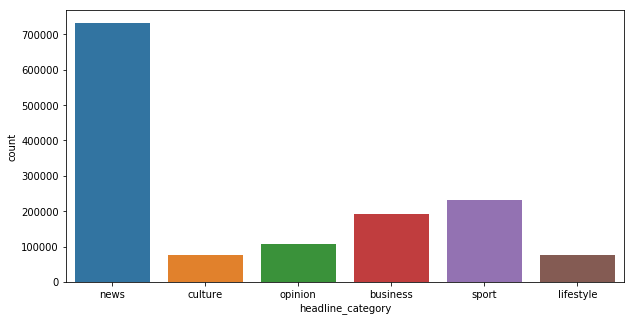

In [15]:
plt.figure(figsize=(10,5))
ax = sns.countplot(data.headline_category) 

Im going to use the WordNetLemmatizer and stopwords with punctuation for filtering the text.

In [16]:
from nltk.corpus import stopwords 
from nltk.tokenize import WordPunctTokenizer
from string import punctuation
from nltk.stem import WordNetLemmatizer
import regex

wordnet_lemmatizer = WordNetLemmatizer()

stop = stopwords.words('english')

for punct in punctuation:
    stop.append(punct)

def filter_text(text, stop_words):
    word_tokens = WordPunctTokenizer().tokenize(text.lower())
    filtered_text = [regex.sub(u'\p{^Latin}', u'', w) for w in word_tokens if w.isalpha()]
    filtered_text = [wordnet_lemmatizer.lemmatize(w, pos="v") for w in filtered_text if not w in stop_words] 
    return " ".join(filtered_text)

In [17]:
data["filtered_text"] = data.headline_text.apply(lambda x : filter_text(x, stop)) 

In [18]:
data.head()

headline_category                                    headline_text  year  \
0              news         UUP sees possibility of voting Major out  1996   
1              news   Pubs targeted as curbs on smoking are extended  1996   
2              news  Papers reveal secret links with O'Neill cabinet  1996   
3              news      Domestic chaos as Italy takes EU presidency  1996   
4              news     Learning about the star to which we owe life  1996   

   month  day                            filtered_text  
0      1    2           uup see possibility vote major  
1      1    2            pubs target curb smoke extend  
2      1    2   paper reveal secret link neill cabinet  
3      1    2  domestic chaos italy take eu presidency  
4      1    2                      learn star owe life

# Exploring the Data

## Date analysis 

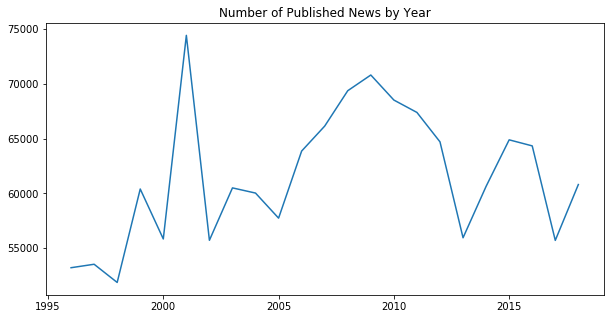

In [19]:
plt.figure(figsize=(10,5))
ax = sns.lineplot(x=data.year.value_counts().index.values,y=data.year.value_counts().values)
ax = plt.title('Number of Published News by Year')

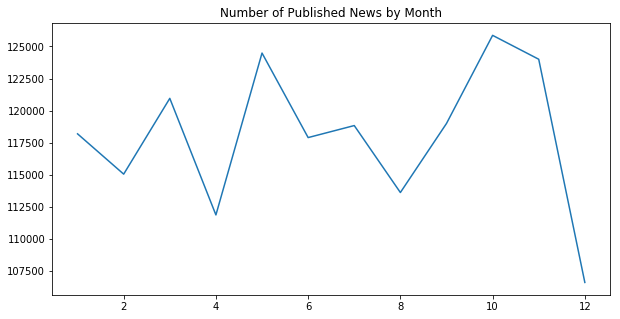

In [20]:
plt.figure(figsize=(10,5))
ax = sns.lineplot(x=data.month.value_counts().index.values,y=data.month.value_counts().values)
ax = plt.title('Number of Published News by Month')

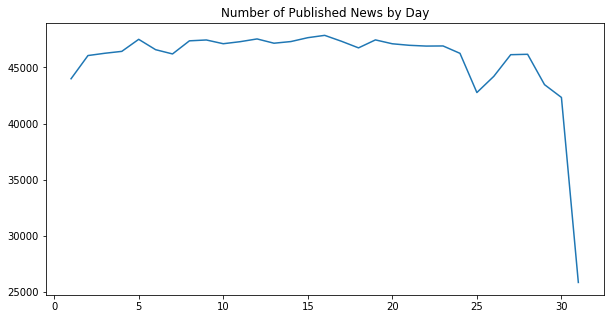

In [21]:
plt.figure(figsize=(10,5))
ax = sns.lineplot(x=data.day.value_counts().index.values,y=data.day.value_counts().values)
ax = plt.title('Number of Published News by Day')

## Word Clouds

In [22]:
from wordcloud import WordCloud

def make_wordcloud(words,title):
    cloud = WordCloud(width=1920, height=1080,max_font_size=200, max_words=300, background_color="white").generate(words)
    plt.figure(figsize=(20,20))
    plt.imshow(cloud, interpolation="gaussian")
    plt.axis("off") 
    plt.title(title, fontsize=60)
    plt.show()

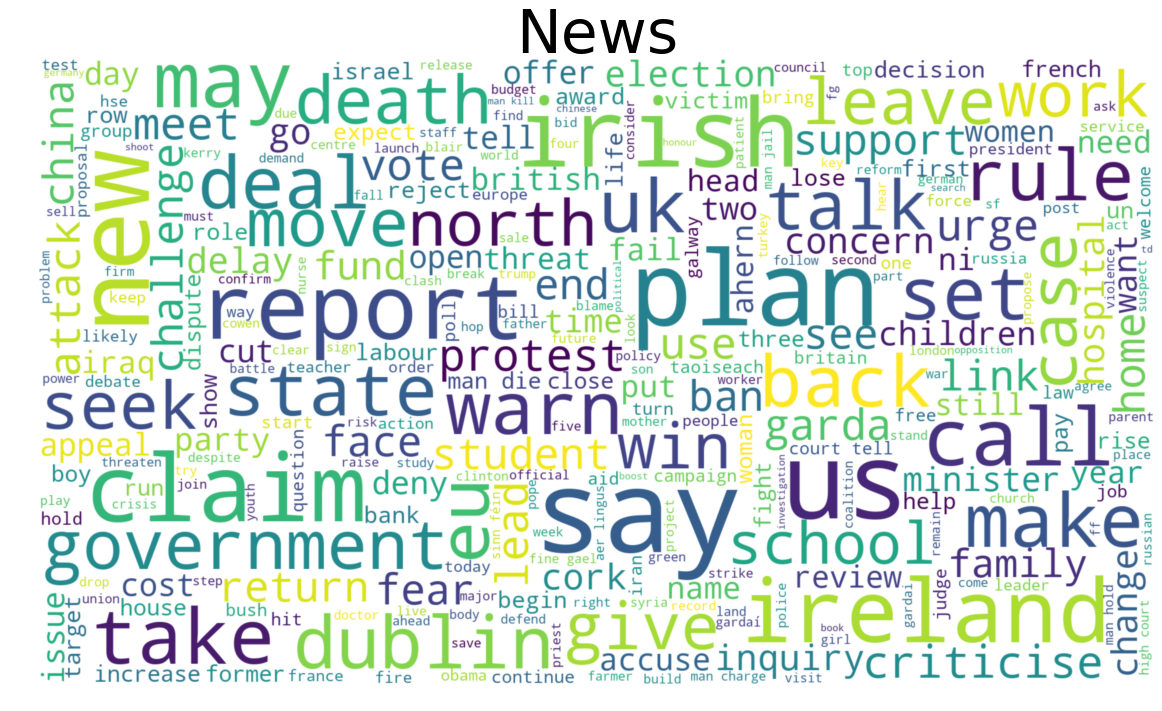

In [23]:
all_text = " ".join(data[data.headline_category == "news"].filtered_text) 
make_wordcloud(all_text, "News") 

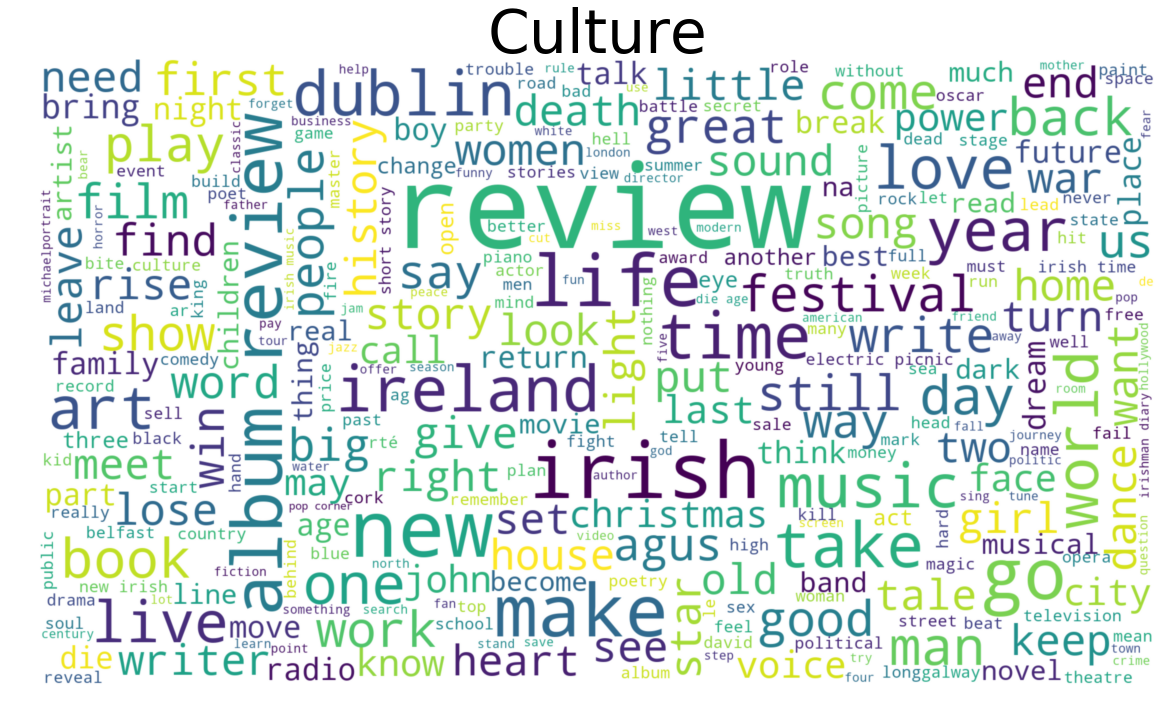

In [24]:
all_text = " ".join(data[data.headline_category == "culture"].filtered_text) 
make_wordcloud(all_text, "Culture")

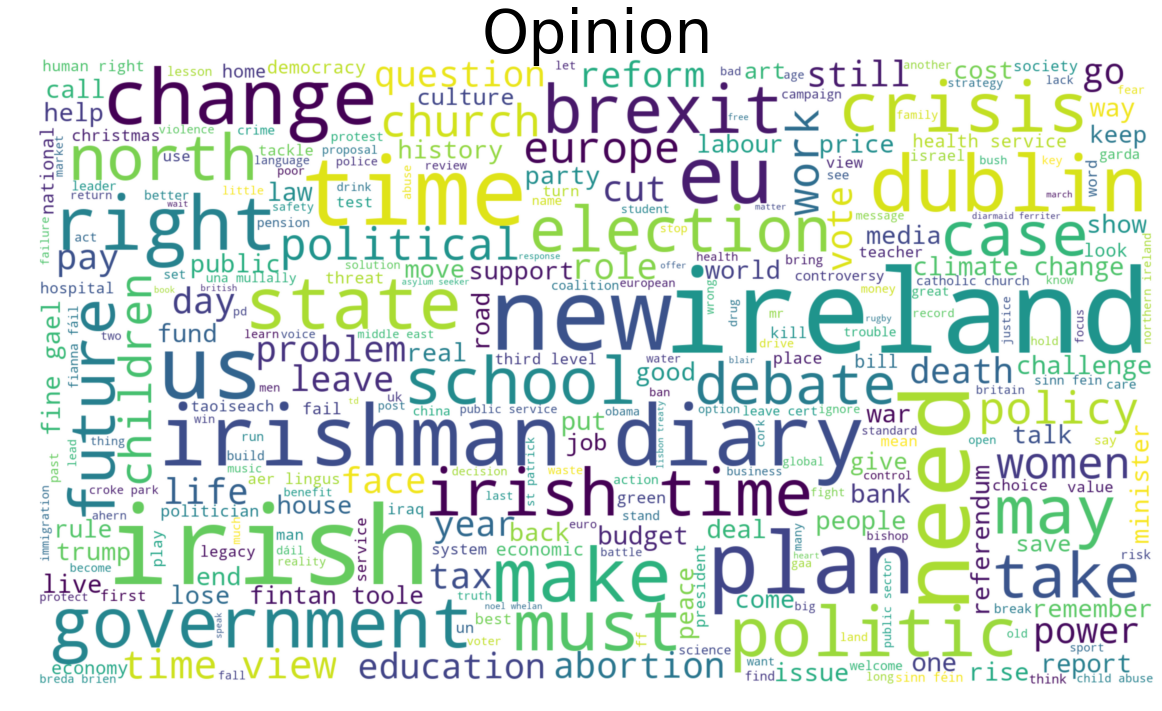

In [25]:
all_text = " ".join(data[data.headline_category == "opinion"].filtered_text) 
make_wordcloud(all_text, "Opinion")

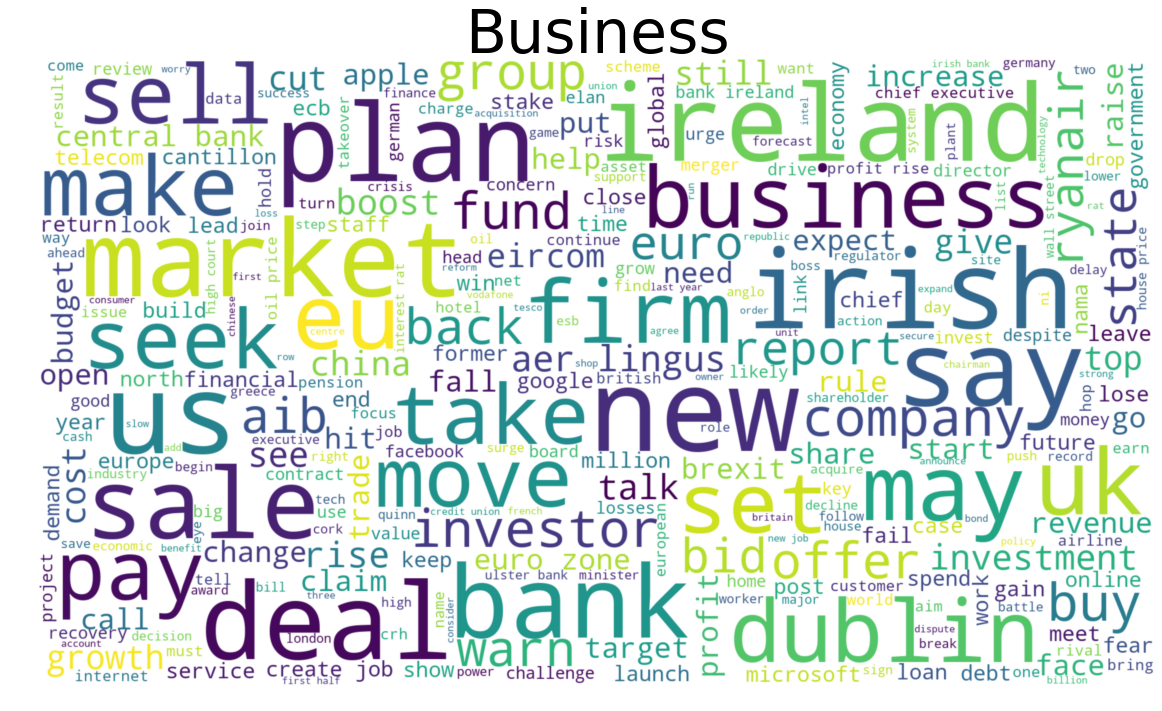

In [26]:
all_text = " ".join(data[data.headline_category == "business"].filtered_text) 
make_wordcloud(all_text, "Business")

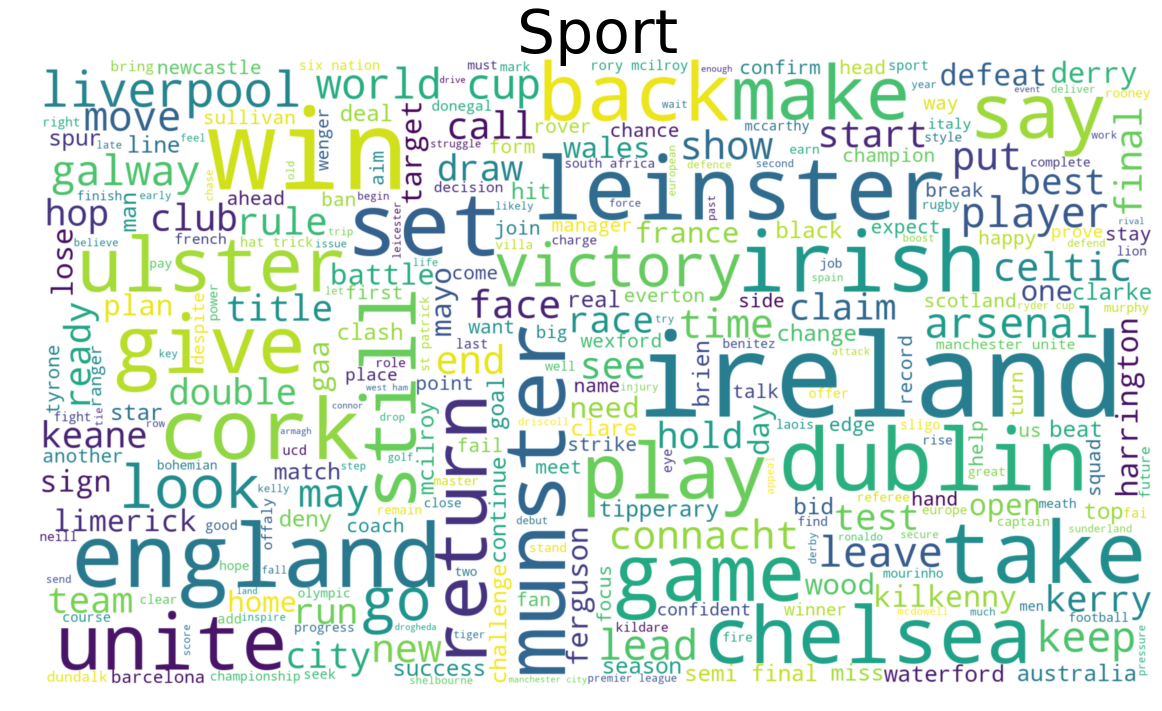

In [27]:
all_text = " ".join(data[data.headline_category == "sport"].filtered_text) 
make_wordcloud(all_text, "Sport")

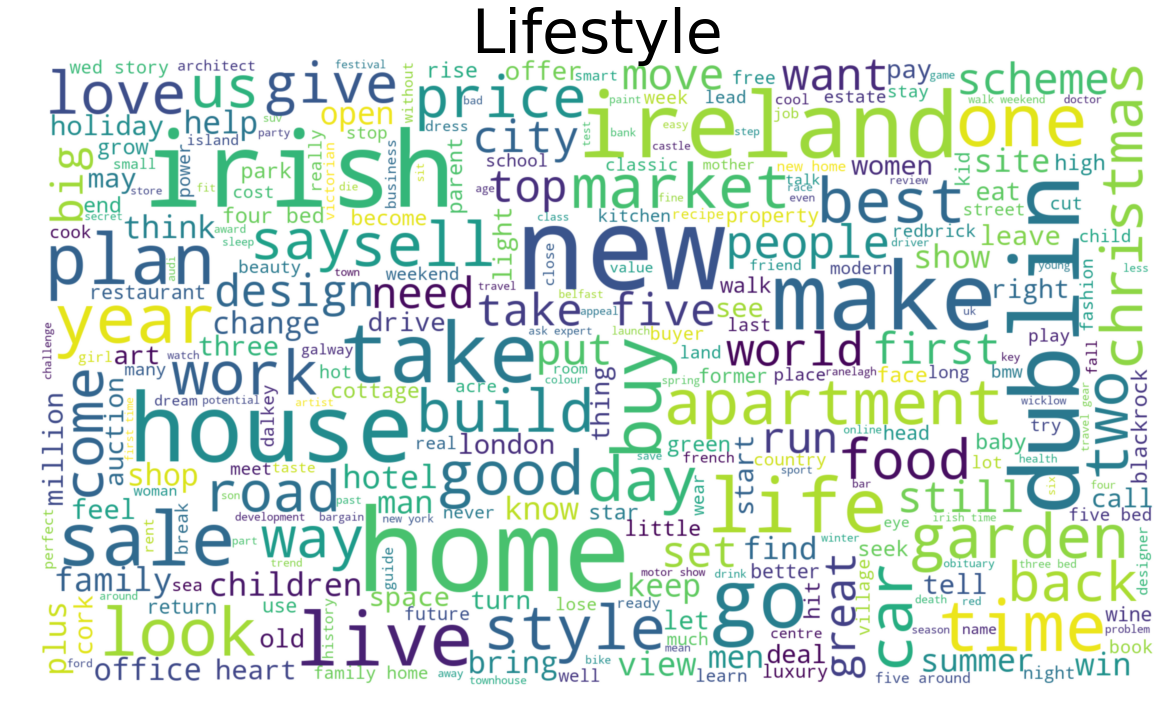

In [28]:
all_text = " ".join(data[data.headline_category == "lifestyle"].filtered_text) 
make_wordcloud(all_text, "Lifestyle")

As we can see in the word clouds above, each category have very different words, that is very good for the next part which is text classification.

# Predicting the Headlines Categories

Im using the TFIDF Vectorizer to create the input data for the Machine Learning algorithm.

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(lowercase=False)
ml_data = tfidf.fit_transform(data['filtered_text'])

In [30]:
ml_data.shape

(1416434, 92257)

In [31]:
data['classification'] = data['headline_category'].replace(['news','culture','opinion','business','sport','lifestyle'],[0,1,2,3,4,5])

In [32]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(ml_data,data['classification'], stratify=data['classification'], test_size=0.2)

I chose to work with the Logistic Regression.

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

model = LogisticRegression(solver='lbfgs',multi_class='auto', max_iter=1000)
model.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Here are the final results:

Test score: 0.73
Cohen Kappa score: 0.58


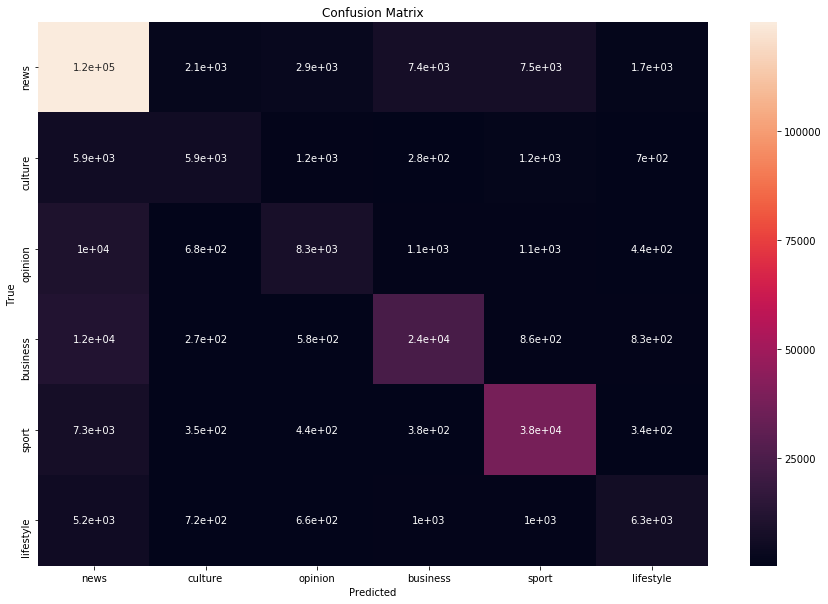

In [34]:
predicted = model.predict(x_test)
print("Test score: {:.2f}".format(accuracy_score(y_test,predicted)))
print("Cohen Kappa score: {:.2f}".format(cohen_kappa_score(y_test,predicted)))
plt.figure(figsize=(15,10))
ax = sns.heatmap(confusion_matrix(y_test,predicted),annot=True)
ax = ax.set(xlabel='Predicted',ylabel='True',title='Confusion Matrix',
            xticklabels=(['news','culture','opinion','business','sport','lifestyle']),
            yticklabels=(['news','culture','opinion','business','sport','lifestyle']))

# Most Important Words for the classifier

In [35]:
def get_most_important_words(model,index,category):
    base = {'news':0,'culture':1,'opinion':2,'business':3,'sport':4,'lifestyle':5}
    t=pd.DataFrame(model.coef_[base[category]].T, index=tfidf.get_feature_names()) 
    return pd.concat([t.nlargest(5,0),t.nsmallest(5,0)])

In [36]:
index = tfidf.get_feature_names()

In [37]:
get_most_important_words(model,index,'news')

0
gardaí     5.475098
murder     5.287308
kill       5.243857
injure     4.969522
urge       4.967659
cantillon -2.886932
tesla     -2.798804
breda     -2.503461
rafael    -2.488435
monkstown -2.485345

In [38]:
get_most_important_words(model,index,'culture')

0
album        6.967802
review       6.398799
ar           6.115551
agus         5.446433
unthinkable  4.468333
uk          -4.806998
charge      -3.589046
profit      -3.394583
cup         -3.352825
firm        -3.043794

In [39]:
get_most_important_words(model,index,'opinion')

0
breda     6.024569
fintan    4.306920
abortion  4.279929
irishman  4.252209
mullally  4.250003
say      -7.051245
urge     -6.805407
launch   -5.626046
announce -5.423010
seek     -5.287012

In [40]:
get_most_important_words(model,index,'business')

0
cantillon  8.423287
footsie    6.013200
tech       5.739041
firm       5.473075
smurfit    5.454166
abortion  -3.942790
murder    -3.259174
ira       -3.164736
sf        -2.854761
rape      -2.797955

In [41]:
get_most_important_words(model,index,'sport')

0
vinny     6.484988
mourinho  5.954909
munster   5.932935
leinster  5.803471
thornley  5.711519
eu       -6.423024
brexit   -5.506641
bank     -5.289256
children -5.107889
house    -5.042686

In [42]:
get_most_important_words(model,index,'lifestyle')

0
obituary  6.344174
audi      5.108138
redbrick  5.020650
jennifer  5.009492
barfly    4.954115
inquiry  -3.334774
ni       -3.275628
court    -3.003122
croke    -2.907476
ahern    -2.884945